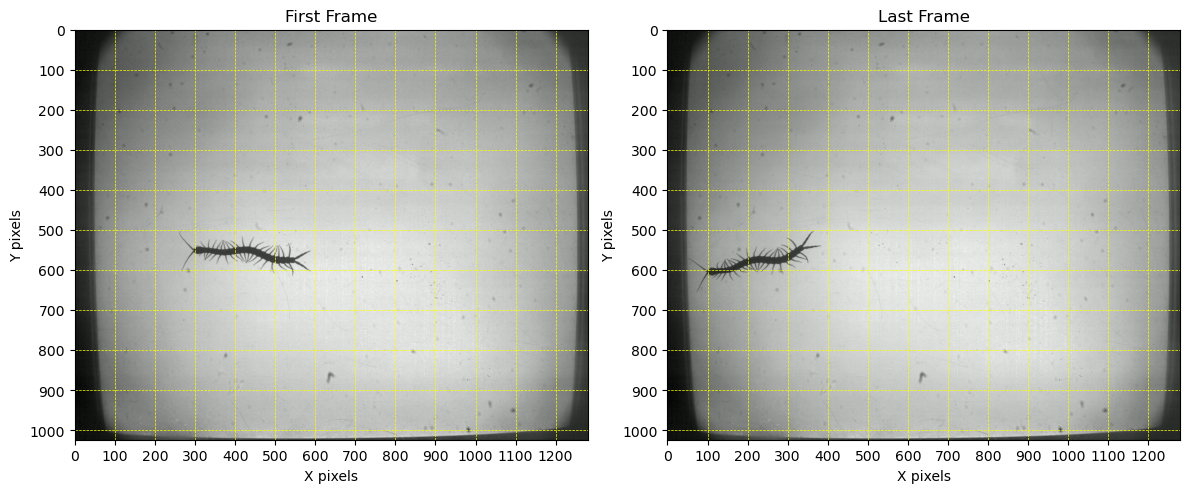

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np



param_dict = {
    "body ant ratio": 0.1,
    "min thresh": 120,
    "top weight": 1,
    "bottom weight": 1,
    "left weight": 1,
    "right weight": 1,
    "mask top": 10,
    "mask bottom": 20,
    "mask left": 70,
    "mask right": 40
}

def mask_frame(frame, mask_vals, val=255):
    """Mask components from window of video

    Args:
        frame (_type_): frame to be masked
        mask_vals (_type_): how much is masked from each side of the frame

    Returns:
        _type_: new frame
    """
    top, bottom, left, right = mask_vals
    height, width = frame.shape
    frame[:top, :] = val            # Top region
    frame[height - bottom:, :] = val  # Bottom region
    frame[:, :left] = val        # Left region
    frame[:, width - right:] = val   # Right region
    return frame

def process_frame(frame, global_min_thresh):
    """Process the frame to leave only legs and midline of the centipede."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    midline_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    small_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # adaptive thresholding to use different threshold 
    # values on different regions of the frame.
    blur = ~gray


    ret, thresh = cv2.threshold(blur, global_min_thresh, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    largest_contour_index = max(range(len(contours)), key=lambda i: cv2.contourArea(contours[i]))
    contours = [contour for i, contour in enumerate(contours) if i != largest_contour_index]
    cv2.drawContours(thresh, contours, -1, 0, thickness=cv2.FILLED)

    cv2.imwrite("frame.png", thresh)

    midline = cv2.erode(thresh, midline_kernel, iterations=1)


    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    opened = cv2.dilate(opened, small_kernel, iterations=1)
    legs_only_frame = thresh & ~opened


    midline = cv2.GaussianBlur(midline, (27, 27), 0)
    binary_bool = midline > 0
    skeleton = skeletonize(binary_bool)
    skeleton = (skeleton * 255).astype(np.uint8)
    
    midline_contour, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(midline_contour) == 0:
        raise Exception("Parameters are not valid for this video. Please adjust the parameters in the UI.")
    else:
        midline_contour = midline_contour[0]
        find_head(midline_contour)


    midline_and_legs = legs_only_frame | skeleton
    white_frame = ~midline_and_legs

    return white_frame


# --- load video ---
cap = cv2.VideoCapture(r"C:\Users\data\Documents\gatech assignments\CrabLab\centipede_tracker2\compressed\polym_t1_d6.mp4")
if not cap.isOpened():
    raise RuntimeError("❌ Cannot open video")

# get number of frames
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# read first frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, first_frame = cap.read()
if not ret:
    raise RuntimeError("❌ Failed to read first frame")

# read last frame
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count - 1)
ret, last_frame = cap.read()
if not ret:
    raise RuntimeError("❌ Failed to read last frame")

cap.release()

# convert BGR (OpenCV) -> RGB (matplotlib)
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
last_frame = cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB)


# --- plotting ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, frame, title in zip(axes, [first_frame, last_frame], ["First Frame", "Last Frame"]):
    ax.imshow(frame)
    ax.set_title(title)
    
    # show pixel coordinates on axes
    h, w = frame.shape[:2]
    ax.set_xticks(np.arange(0, w+1, 100))
    ax.set_yticks(np.arange(0, h+1, 100))
    ax.grid(color="yellow", linestyle="--", linewidth=0.5)
    ax.set_xlabel("X pixels")
    ax.set_ylabel("Y pixels")

plt.tight_layout()
plt.show()